## SBTi Target Status


Font 'default' does not have a glyph for '\U0001f4c8' [U+1f4c8], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\U0001f4c8' [U+1f4c8], substituting with a dummy symbol.


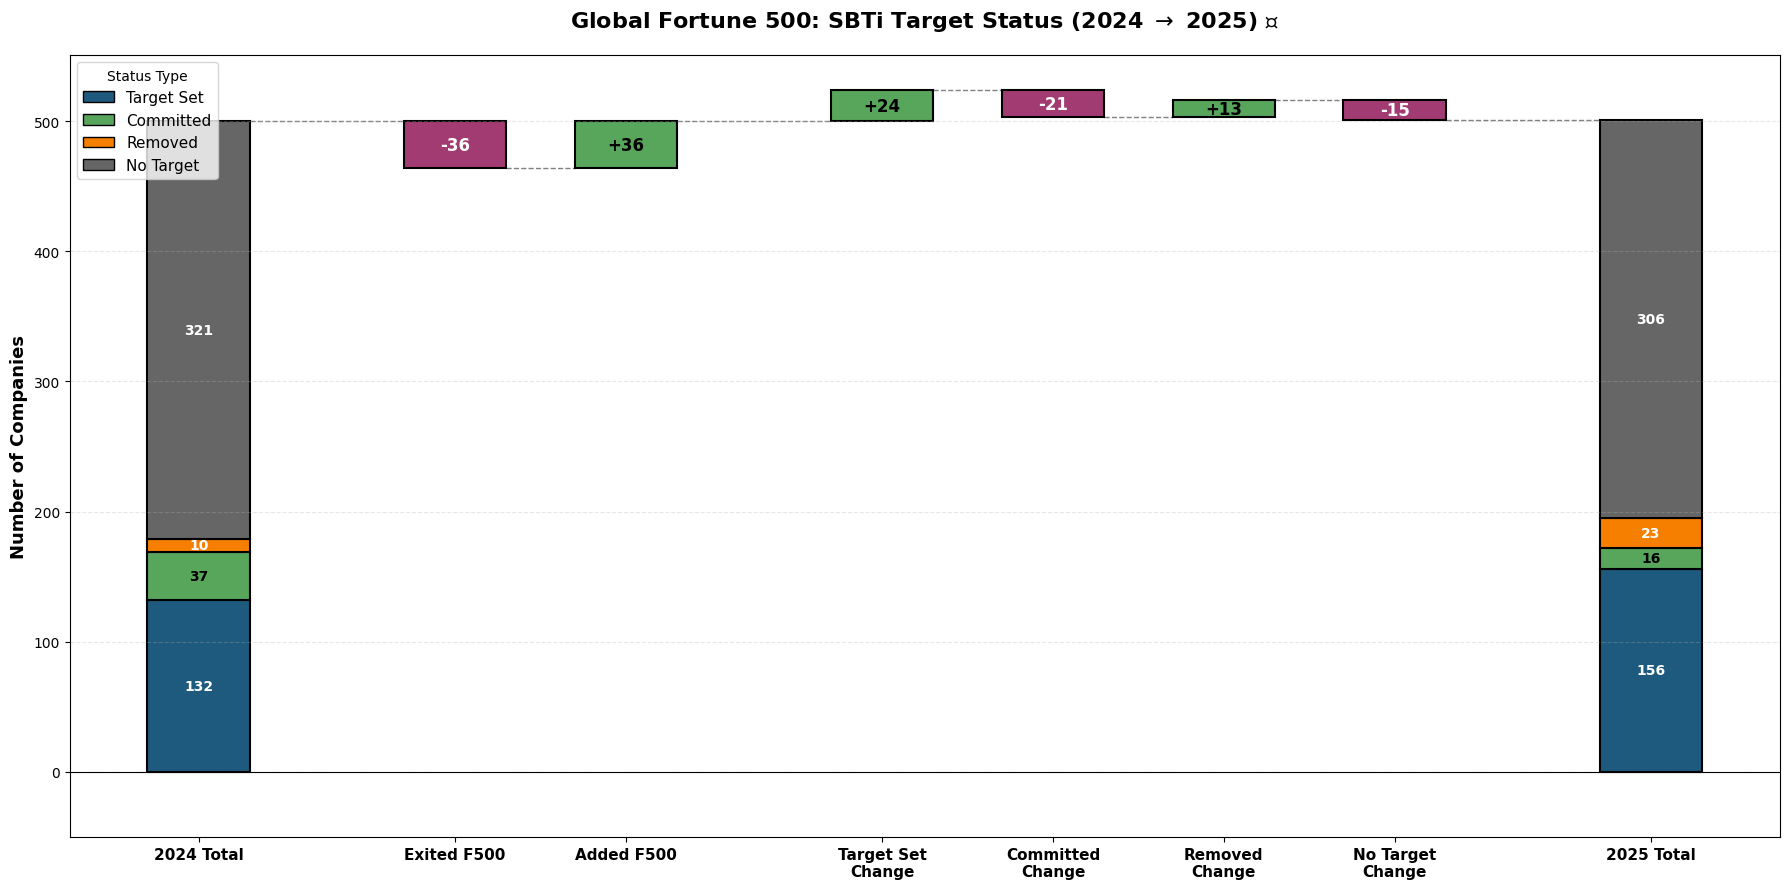

<Figure size 640x480 with 0 Axes>

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())

def map_status_2024(row):
    status = str(row['Target status - NT']).strip()
    if status == 'Targets Set': return 'Target Set'
    elif status == 'Committed': return 'Committed'
    elif status == 'Removed': return 'Removed'
    return 'No Target'

def map_status_2025(row):
    status = str(row['Target status (T = target set, C = committed, N=No, R=Removed)']).strip()
    if status in ['Targets set', 'T']: return 'Target Set'
    elif status in ['Committed', 'C']: return 'Committed'
    elif status in ['Removed', 'Commitment removed', 'R']: return 'Removed'
    return 'No Target'

s2024 = df_2024.apply(map_status_2024, axis=1).value_counts().to_dict()
s2025 = df_2025.apply(map_status_2025, axis=1).value_counts().to_dict()

# --- Custom Waterfall Colors and Status Order ---
STATUS_ORDER = ['Target Set', 'Committed', 'Removed', 'No Target']
COLOR_MAP = {
    'Target Set': '#1E5A7D',
    'Committed': '#58A55C',
    'Removed': '#F77F00',
    'No Target': '#666666',
    'Decrease': '#A23B72',  # General decrease/Exit
    'Increase': '#58A55C', # General increase/Add
}

# --- Data Setup (Your original logic) ---
categories = ['2024 Total', 'Exited F500', 'Added F500', 'Target Set\nChange', 
              'Committed\nChange', 'Removed\nChange', 'No Target\nChange', '2025 Total']
values = [
    sum(s2024.values()), # Use sum(s2024.values()) instead of fixed 500 for robustness
    -len(companies_2024 - companies_2025), 
    len(companies_2025 - companies_2024),
    s2025.get('Target Set', 0) - s2024.get('Target Set', 0),
    s2025.get('Committed', 0) - s2024.get('Committed', 0),
    s2025.get('Removed', 0) - s2024.get('Removed', 0),
    s2025.get('No Target', 0) - s2024.get('No Target', 0), 
    sum(s2025.values()) # Use sum(s2025.values())
]

# X-axis positions (adjusted for better spacing)
x_pos = [0, 1.5, 2.5, 4, 5, 6, 7, 8.5] 

# Calculate the cumulative base for drawing change bars
cumulative = [0]
for v in values[:-1]:
    cumulative.append(cumulative[-1] + v)

# --- NEW: Function to draw connectors ---
def draw_connector(ax, x_start, y_start, x_end):
    """Draws the horizontal connecting line from one bar to the next."""
    ax.plot([x_start + 0.3, x_end - 0.3], [y_start, y_start], 
            color='gray', linestyle='--', linewidth=1.0, zorder=0)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(18, 9))
bar_width = 0.6
previous_bar_top = 0 # Track the top of the previous bar for drawing connectors

for i, (x, val) in enumerate(zip(x_pos, values)):
    is_total_bar = i == 0 or i == 7
    current_data = s2024 if i == 0 else s2025

    if is_total_bar:
        # Plot 2024 and 2025 Total Bars (Stacked)
        bottom = 0
        current_bar_top = 0
        
        # Plot each status segment
        for status in STATUS_ORDER:
            s_val = current_data.get(status, 0)
            
            # Use the status color from the map
            color = COLOR_MAP.get(status)
            
            ax.bar(x, s_val, bottom=bottom, color=color, width=bar_width, 
                   edgecolor='black', linewidth=1.5, label=status if i == 0 else None)
            
            # Add text label on the bar segment
            if s_val > 0:
                text_y = bottom + s_val / 2
                # Choose text color based on bar color for visibility
                text_color = 'white' if status in ['Target Set', 'No Target', 'Removed'] else 'black'
                ax.text(x, text_y, f'{s_val}', ha='center', va='center', fontsize=10, 
                        fontweight='bold', color=text_color)

            bottom += s_val
            current_bar_top = bottom

    else:
        # Plot Change Bars
        is_negative = val < 0
        
        # Determine color for change bars
        if i == 1: # Exited F500
            col = COLOR_MAP['Decrease'] 
        elif i == 2: # Added F500
            col = COLOR_MAP['Increase']
        elif is_negative:
            col = COLOR_MAP['Decrease'] # Use decrease color for status loss
        else:
            col = COLOR_MAP['Increase'] # Use increase color for status gain
            
        # The base of the bar is the cumulative total
        bottom = cumulative[i] if val > 0 else cumulative[i] + val
        ax.bar(x, abs(val), bottom=bottom, color=col, width=bar_width, 
               edgecolor='black', linewidth=1.5)
        
        # Add text label in the middle of the change bar
        text_y = cumulative[i] + val / 2
        ax.text(x, text_y, f'{val:+d}', ha='center', va='center', fontsize=12, 
                fontweight='bold', color='white' if col != COLOR_MAP['Increase'] else 'black')
        
        current_bar_top = cumulative[i] + val

    # --- Draw Connector Lines (Except after the last bar) ---
    if i < len(x_pos) - 1:
        # Draw the line from the top of the current bar to the base of the next bar
        draw_connector(ax, x, current_bar_top, x_pos[i+1])
        
    previous_bar_top = current_bar_top


# --- Styling and Annotations ---
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Companies', fontsize=13, fontweight='bold')
ax.set_title('Global Fortune 500: SBTi Target Status (2024 $\\to$ 2025) 📈', fontsize=16, fontweight='bold', pad=20)

# Re-create legend using the correct colors and only for the status segments
legend_handles = [plt.Rectangle((0,0),1,1, fc=COLOR_MAP[key], ec='black') for key in STATUS_ORDER]
ax.legend(legend_handles, STATUS_ORDER, loc='upper left', fontsize=11, title='Status Type', frameon=True)

ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylim(-50, max(values[0], values[-1]) + 50) # Set Y-limit based on total

plt.tight_layout()
plt.show()
plt.savefig('waterfall_sbti_modified.png', dpi=300, bbox_inches='tight')

In [47]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

def map_status_2024(row):
    status = str(row['Target status - NT']).strip()
    if status == 'Targets Set': return 'Target Set'
    elif status == 'Committed': return 'Committed'
    elif status == 'Removed': return 'Removed'
    return 'No Target'

def map_status_2025(row):
    status = str(row['Target status (T = target set, C = committed, N=No, R=Removed)']).strip()
    if status in ['Targets set', 'T']: return 'Target Set'
    elif status in ['Committed', 'C']: return 'Committed'
    elif status in ['Removed', 'Commitment removed', 'R']: return 'Removed'
    return 'No Target'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

transitions = {}
for company in continuing:
    old = map_status_2024(df_2024_indexed.loc[company])
    new = map_status_2025(df_2025_indexed.loc[company])
    transitions[(old, new)] = transitions.get((old, new), 0) + 1

labels = ['2024: Target Set', '2024: Committed', '2024: Removed', '2024: No Target',
          '2025: Target Set', '2025: Committed', '2025: Removed', '2025: No Target']
label_map = {'Target Set': 0, 'Committed': 1, 'Removed': 2, 'No Target': 3}

source, target, value, link_colors = [], [], [], []

for (old, new), count in transitions.items():
    src = label_map[old]
    tgt = label_map[new] + 4
    source.append(src)
    target.append(tgt)
    value.append(count)
    
    if src == tgt - 4:
        link_colors.append('rgba(200, 200, 200, 0.3)')
    elif src == 0:
        link_colors.append('rgba(30, 90, 125, 0.5)')
    elif src == 1:
        link_colors.append('rgba(88, 165, 92, 0.5)')
    elif src == 2:
        link_colors.append('rgba(247, 127, 0, 0.5)')
    else:
        link_colors.append('rgba(102, 102, 102, 0.5)')

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels, 
              color=['#1E5A7D', '#58A55C', '#F77F00', '#666666', '#1E5A7D', '#58A55C', '#F77F00', '#666666']),
    link=dict(source=source, target=target, value=value, color=link_colors)
)])

fig.update_layout(title_text="SBTi Target Status Transitions (2024 → 2025)", font_size=12, height=600)
fig.write_html('sankey_sbti.html')

## RE100

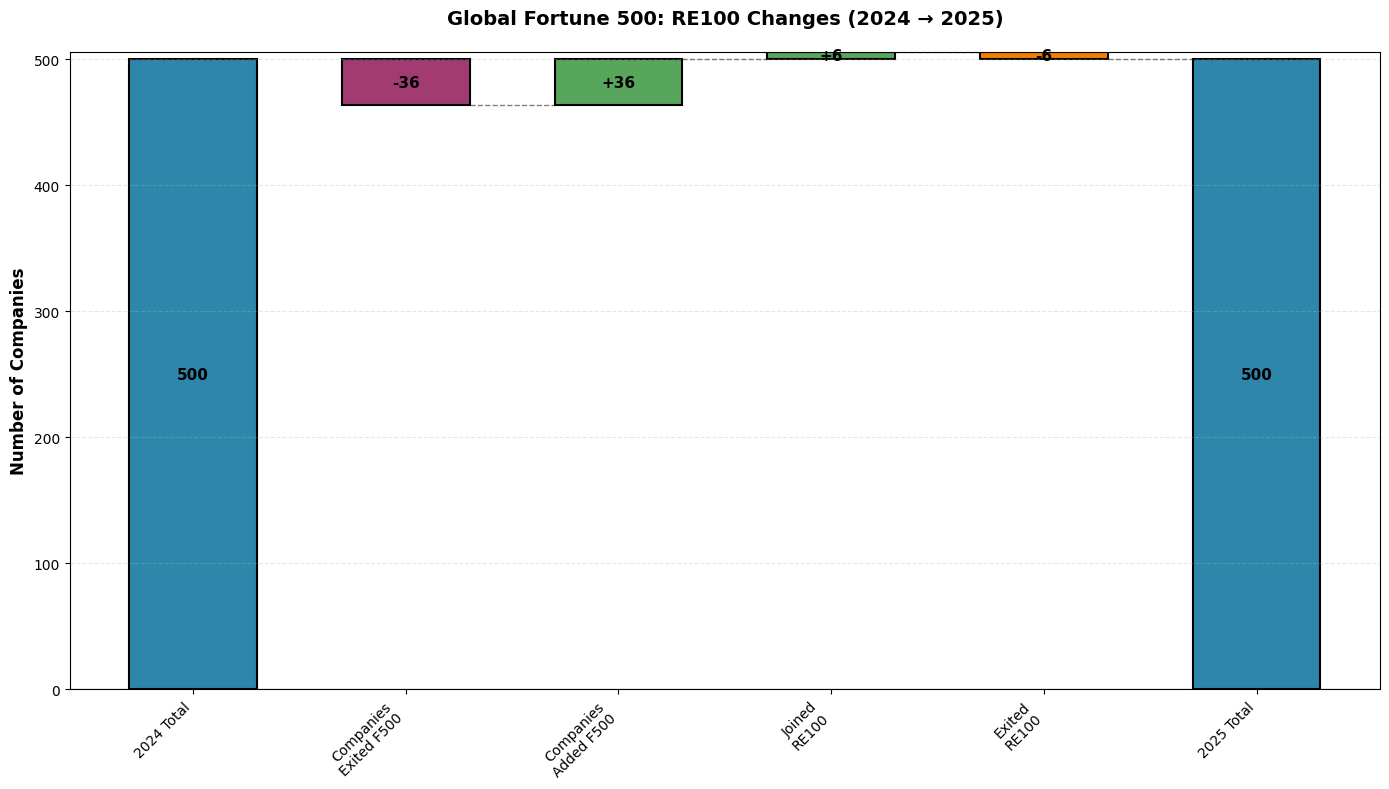

Joined RE100: 6
['Tongwei Group', 'Hon Hai Precision Industry', 'SK', 'Chevron', 'La Poste', 'Commonwealth Bank of Australia']

Exited RE100: 6
['Daiwa House Industry', 'Meta Platforms', 'Capital One Financial', 'Morgan Stanley', 'Siemens', 'Procter & Gamble']


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

# Get company sets
companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

# Map RE100 status
def map_re100(row):
    status = str(row['RE100 (Y/N)']).strip()
    return 'In RE100' if status in ['Yes', 'Y'] else 'Not in RE100'

# Track changes for continuing companies
df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

joined = []
exited_re = []

for company in continuing:
    old = map_re100(df_2024_indexed.loc[company])
    new = map_re100(df_2025_indexed.loc[company])
    if old == 'Not in RE100' and new == 'In RE100':
        joined.append(company)
    elif old == 'In RE100' and new == 'Not in RE100':
        exited_re.append(company)

# Build waterfall
categories = ['2024 Total', 'Companies\nExited F500', 'Companies\nAdded F500', 
              'Joined\nRE100', 'Exited\nRE100', '2025 Total']
values = [500, -len(companies_2024 - companies_2025), len(companies_2025 - companies_2024), 
          len(joined), -len(exited_re), 500]
colors = ['#2E86AB', '#A23B72', '#58A55C', '#58A55C', '#F77F00', '#2E86AB']

# Calculate cumulative
cumulative = [0]
for i, val in enumerate(values[:-1]):
    cumulative.append(val if i == 0 else cumulative[-1] + val)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

for i, (cat, val, col) in enumerate(zip(categories, values, colors)):
    if i == 0 or i == len(categories) - 1:
        ax.bar(i, val, color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = val / 2
        label = f'{val}'
    else:
        ax.bar(i, val, bottom=cumulative[i], color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = cumulative[i] + val / 2
        label = f'{val:+d}'
        if i < len(categories) - 1:
            ax.plot([i + 0.3, i + 0.7], [cumulative[i+1], cumulative[i+1]], 'k--', linewidth=1, alpha=0.5)
    
    ax.text(i, label_pos, label, ha='center', va='center', fontsize=11, fontweight='bold')

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax.set_title('Global Fortune 500: RE100 Changes (2024 → 2025)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('waterfall_re100.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Joined RE100: {len(joined)}")
print(joined)
print(f"\nExited RE100: {len(exited_re)}")
print(exited_re)

In [74]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

def map_re100(row):
    status = str(row['RE100 (Y/N)']).strip()
    return 'In RE100' if status in ['Yes', 'Y'] else 'Not in RE100'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

transitions = {}
for company in continuing:
    old = map_re100(df_2024_indexed.loc[company])
    new = map_re100(df_2025_indexed.loc[company])
    transitions[(old, new)] = transitions.get((old, new), 0) + 1

labels = ['2024: In RE100', '2024: Not in RE100', '2025: In RE100', '2025: Not in RE100']
label_map = {'In RE100': 0, 'Not in RE100': 1}

source, target, value, link_colors = [], [], [], []

for (old, new), count in transitions.items():
    src = label_map[old]
    tgt = label_map[new] + 2
    source.append(src)
    target.append(tgt)
    value.append(count)
    
    if src == 0:
        link_colors.append('rgba(16, 79, 25, 0.5)')
    else:
        link_colors.append('rgba(38, 54, 13, 0.5)')

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels, color=["#104F19", "#26360D", "#BEF7B1", "#8B9C6B"]),
    link=dict(source=source, target=target, value=value, color=link_colors)
)])

fig.update_layout(title_text="RE100 Status Transitions (2024 → 2025)", font_size=12, height=600)
fig.write_html('sankey_re100.html')

In [75]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

def map_re100(row):
    status = str(row['RE100 (Y/N)']).strip()
    return 'RE100' if status in ['Yes', 'Y'] else 'No RE100'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
exited = companies_2024 - companies_2025
added = companies_2025 - companies_2024
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

labels = ['2024: RE100', '2024: No RE100', 'Exited: RE100', 'Exited: No RE100', 
          'Continuing: RE100', 'Continuing: No RE100', 'Added: RE100', 'Added: No RE100',
          '2025: RE100', '2025: No RE100']

source, target, value, link_colors = [], [], [], []

# 2024 to Exited/Continuing
for company in exited:
    status = map_re100(df_2024_indexed.loc[company])
    if status == 'RE100':
        source.append(0)
        target.append(2)
    else:
        source.append(1)
        target.append(3)
    value.append(1)
    link_colors.append('rgba(200, 0, 0, 0.3)')

for company in continuing:
    status = map_re100(df_2024_indexed.loc[company])
    if status == 'RE100':
        source.append(0)
        target.append(4)
    else:
        source.append(1)
        target.append(5)
    value.append(1)
    link_colors.append('rgba(100, 100, 100, 0.2)')

# Continuing transitions
for company in continuing:
    old = map_re100(df_2024_indexed.loc[company])
    new = map_re100(df_2025_indexed.loc[company])
    if old == 'RE100' and new == 'RE100':
        source.append(4)
        target.append(8)
    elif old == 'RE100' and new == 'No RE100':
        source.append(4)
        target.append(9)
    elif old == 'No RE100' and new == 'RE100':
        source.append(5)
        target.append(8)
    else:
        source.append(5)
        target.append(9)
    value.append(1)
    link_colors.append('rgba(16, 79, 25, 0.4)' if new == 'RE100' else 'rgba(38, 54, 13, 0.4)')

# Added to 2025
for company in added:
    status = map_re100(df_2025_indexed.loc[company])
    if status == 'RE100':
        source.append(6)
        target.append(8)
    else:
        source.append(7)
        target.append(9)
    value.append(1)
    link_colors.append('rgba(0, 200, 0, 0.3)')

# Aggregate flows
flow_dict = {}
color_dict = {}
for s, t, v, c in zip(source, target, value, link_colors):
    key = (s, t)
    flow_dict[key] = flow_dict.get(key, 0) + v
    color_dict[key] = c

source_agg = [k[0] for k in flow_dict.keys()]
target_agg = [k[1] for k in flow_dict.keys()]
value_agg = list(flow_dict.values())
colors_agg = [color_dict[k] for k in flow_dict.keys()]

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels),
    link=dict(source=source_agg, target=target_agg, value=value_agg, color=colors_agg)
)])

fig.update_layout(title_text="RE100 Transitions with Entry/Exit (2024 → 2025)", font_size=12, height=800)
fig.write_html('sankey_re100_full.html')

## Carbon Credits


Font 'default' does not have a glyph for '\U0001f4c9' [U+1f4c9], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\U0001f4c9' [U+1f4c9], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\U0001f4c9' [U+1f4c9], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\U0001f4c9' [U+1f4c9], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\U0001f4c9' [U+1f4c9], substituting with a dummy symbol.


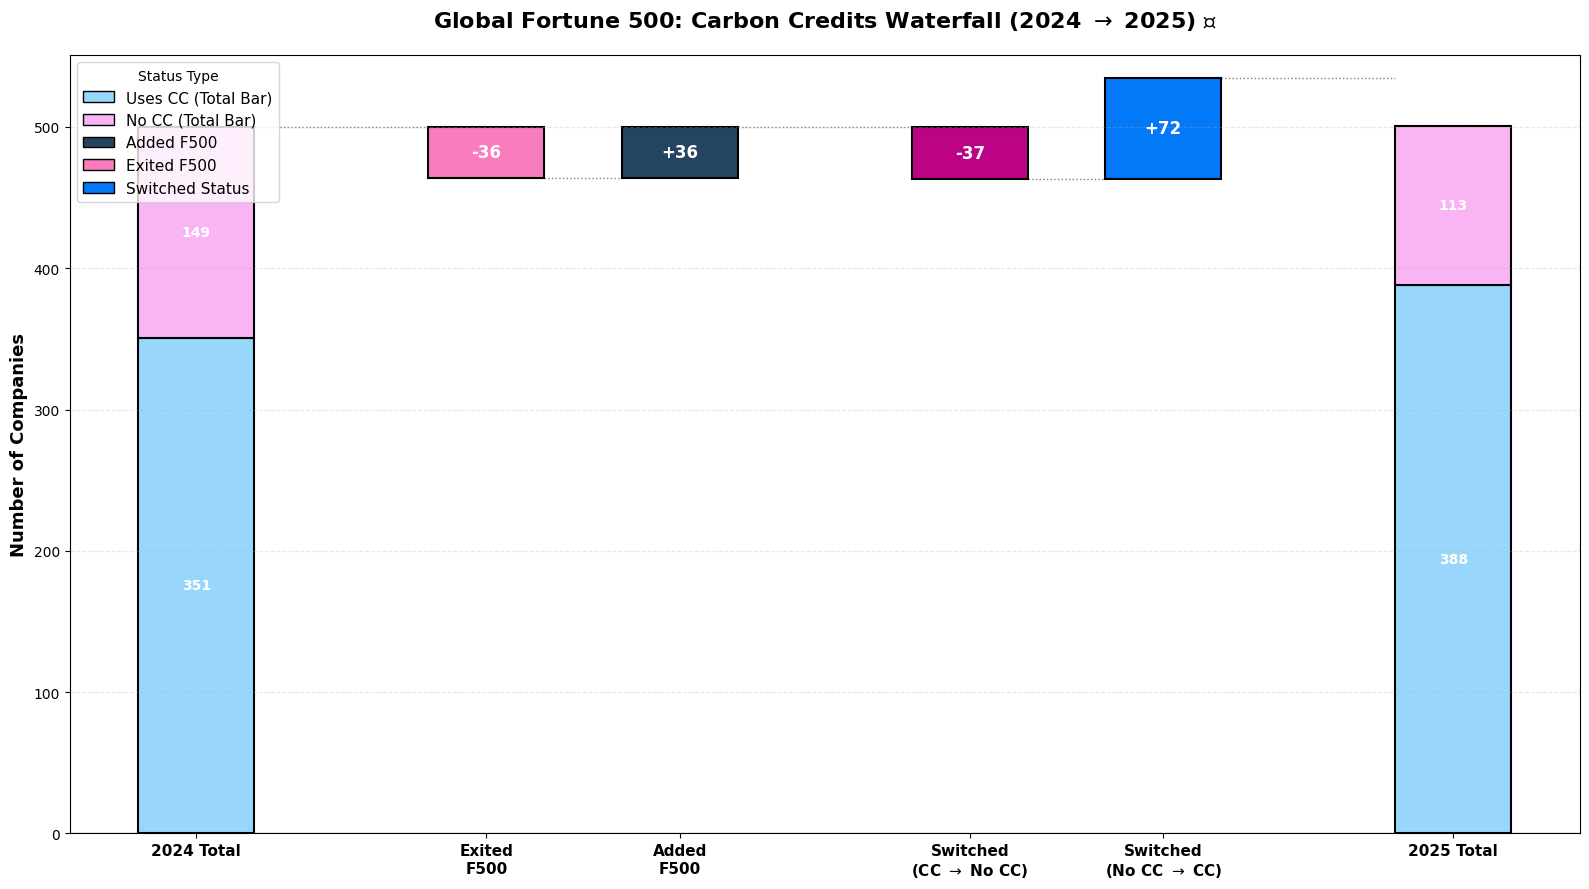

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Data Loading and Preparation (Same as original) ---
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

def map_cc_2024(row):
    cc1 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear)']).strip()
    cc2 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    return 'Uses CC' if cc1 in ['Y', 'R', 'U'] or cc2 in ['Y', 'R', 'U'] else 'No CC'

def map_cc_2025(row):
    cc = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    return 'Uses CC' if cc in ['Yes', 'Y', 'R', 'U', 'Not Specified'] else 'No CC'

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

# --- 1. Calculate Initial and Final Status Counts ---
s2024_cc = df_2024.apply(map_cc_2024, axis=1).value_counts().to_dict()
s2025_cc = df_2025.apply(map_cc_2025, axis=1).value_counts().to_dict()

# --- 2. Calculate Behavioral Changes (Only for continuing companies) ---
started = sum(1 for c in continuing if map_cc_2024(df_2024_indexed.loc[c]) == 'No CC' and map_cc_2025(df_2025_indexed.loc[c]) == 'Uses CC')
stopped = sum(1 for c in continuing if map_cc_2024(df_2024_indexed.loc[c]) == 'Uses CC' and map_cc_2025(df_2025_indexed.loc[c]) == 'No CC')

# --- 3. Define the Corrected Categories and Values (REORDERED) ---

categories = [
    '2024 Total', 
    'Exited\nF500', 
    'Added\nF500',
    'Switched\n(CC $\\to$ No CC)',     # NEGATIVE change placed first
    'Switched\n(No CC $\\to$ CC)',    # POSITIVE change placed second
    '2025 Total'
]

values = [
    sum(s2024_cc.values()),         # 2024 Total
    -len(companies_2024 - companies_2025), # Exited F500 
    len(companies_2025 - companies_2024),  # Added F500 
    -stopped,                             # Companies that stopped using CC (Negative change)
    started,                              # Companies that started using CC (Positive change)
    sum(s2025_cc.values())          # 2025 Total
]

# --- 4. Define Custom Waterfall Colors and Status Order ---
STATUS_ORDER = ['Uses CC', 'No CC']
COLOR_MAP = {
    'Uses CC': "#98D7FB",   
    'No CC': "#F8B4F3",     
    'Exited': "#F87CBE",    
    'Added': "#254461",     
    'Switched_In': "#0379F8", # Started using CC (Positive change)
    'Switched_Out': "#BD0385",# Stopped using CC (Negative change)
}

# X-axis positions (adjusted for spacing)
x_pos = [0, 1.5, 2.5, 4, 5, 6.5]

# Calculate the cumulative base for drawing change bars
cumulative = [0]
for v in values[:-1]:
    cumulative.append(cumulative[-1] + v)

# --- NEW: Function to draw connectors ---
def draw_connector(ax, x_start, y_start, x_end):
    """Draws the horizontal connecting line from one bar to the next."""
    ax.plot([x_start + 0.3, x_end - 0.3], [y_start, y_start],
            color='gray', linestyle='dotted', linewidth=1.0, zorder=0)

# --- 5. Plotting ---
fig, ax = plt.subplots(figsize=(16, 9))
bar_width = 0.6
previous_bar_top = 0 

for i, (x, val) in enumerate(zip(x_pos, values)):
    is_total_bar = i == 0 or i == len(x_pos) - 1
    current_data = s2024_cc if i == 0 else s2025_cc

    if is_total_bar:
        # Plot 2024 and 2025 Total Bars (Stacked)
        bottom = 0
        current_bar_top = 0
        
        # Plot each CC status segment
        for status in STATUS_ORDER:
            s_val = current_data.get(status, 0)
            color = COLOR_MAP.get(status)
            
            ax.bar(x, s_val, bottom=bottom, color=color, width=bar_width, 
                   edgecolor='black', linewidth=1.5, label=status if i == 0 else None)
            
            # Add text label on the bar segment
            if s_val > 0:
                text_y = bottom + s_val / 2
                text_color = 'white' if status in ['Uses CC', 'No CC'] else 'black'
                ax.text(x, text_y, f'{s_val}', ha='center', va='center', fontsize=10, 
                        fontweight='bold', color=text_color)

            bottom += s_val
            current_bar_top = bottom

    else:
        # Plot Change Bars (Single Bar)
        
        # Determine color for change bars based on the category (index)
        if i == 1: # Exited F500
            col = COLOR_MAP['Exited'] 
        elif i == 2: # Added F500
            col = COLOR_MAP['Added']
        elif i == 3: # Switched (CC -> No CC)
            col = COLOR_MAP['Switched_Out']
        elif i == 4: # Switched (No CC -> CC)
            col = COLOR_MAP['Switched_In']
        
        # The base of the bar is the cumulative total
        bottom = cumulative[i] if val > 0 else cumulative[i] + val
        ax.bar(x, abs(val), bottom=bottom, color=col, width=bar_width, 
               edgecolor='black', linewidth=1.5)
        
        # Add text label in the middle of the change bar
        text_y = cumulative[i] + val / 2
        ax.text(x, text_y, f'{val:+d}', ha='center', va='center', fontsize=12, 
                fontweight='bold', color='white')
        
        current_bar_top = cumulative[i] + val

    # --- Draw Connector Lines (Except after the last bar) ---
    if i < len(x_pos) - 1:
        # Draw the line from the top of the current bar to the base of the next bar
        draw_connector(ax, x, current_bar_top, x_pos[i+1])
        
    previous_bar_top = current_bar_top


# --- 6. Styling and Annotations ---
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Companies', fontsize=13, fontweight='bold')
ax.set_title('Global Fortune 500: Carbon Credits Waterfall (2024 $\\to$ 2025) 📉', fontsize=16, fontweight='bold', pad=20)

# Re-create legend
legend_handles = [
    plt.Rectangle((0,0),1,1, fc=COLOR_MAP['Uses CC'], ec='black'), 
    plt.Rectangle((0,0),1,1, fc=COLOR_MAP['No CC'], ec='black'),
    plt.Rectangle((0,0),1,1, fc=COLOR_MAP['Added'], ec='black'),
    plt.Rectangle((0,0),1,1, fc=COLOR_MAP['Exited'], ec='black'),
    plt.Rectangle((0,0),1,1, fc=COLOR_MAP['Switched_In'], ec='black') 
]
legend_labels = ['Uses CC (Total Bar)', 'No CC (Total Bar)', 'Added F500', 'Exited F500', 'Switched Status']
ax.legend(legend_handles, legend_labels, loc='upper left', fontsize=11, title='Status Type', frameon=True)

ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylim(0, max(values[0], values[-1]) * 1.1)

plt.tight_layout()
plt.savefig('waterfall_carbon_credits_reordered.png', dpi=300, bbox_inches='tight')
plt.show()

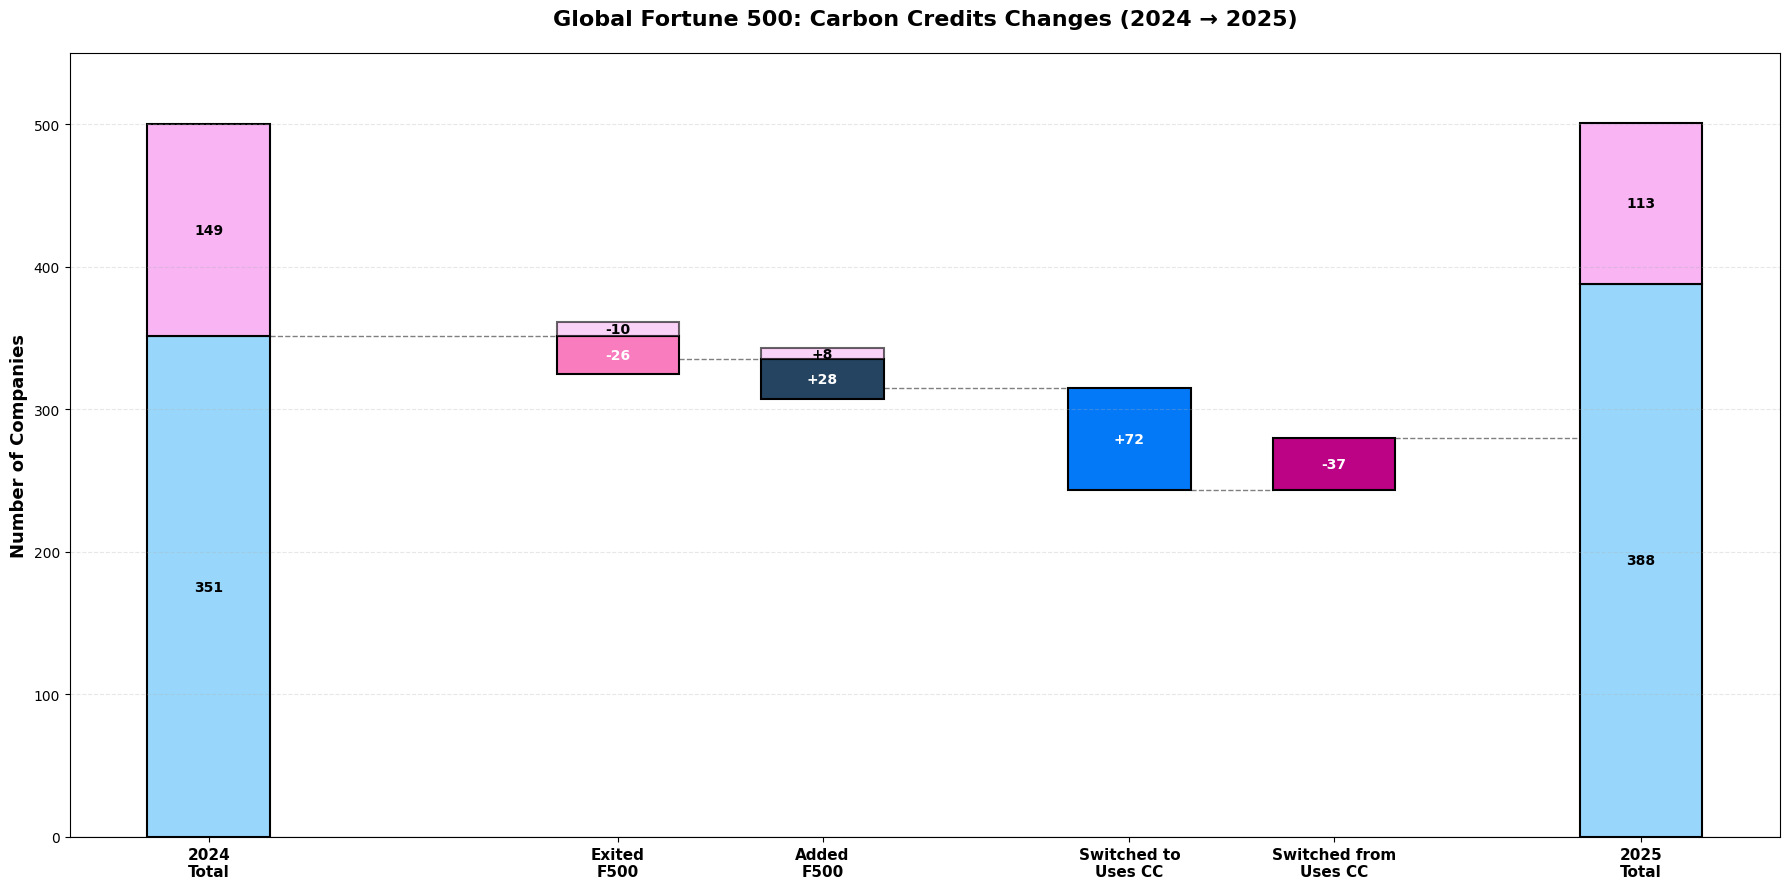

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

def map_cc_2024(row):
    cc1 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear)']).strip()
    cc2 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    return 'Uses CC' if cc1 in ['Y', 'R', 'U'] or cc2 in ['Y', 'R', 'U'] else 'No CC'

def map_cc_2025(row):
    cc = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    return 'Uses CC' if cc in ['Yes', 'Y', 'R', 'U', 'Not Specified'] else 'No CC'

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

exited = companies_2024 - companies_2025
added = companies_2025 - companies_2024

exited_cc = sum(1 for c in exited if map_cc_2024(df_2024_indexed.loc[c]) == 'Uses CC')
exited_no = len(exited) - exited_cc
added_cc = sum(1 for c in added if map_cc_2025(df_2025_indexed.loc[c]) == 'Uses CC')
added_no = len(added) - added_cc

switched_to = sum(1 for c in continuing if map_cc_2024(df_2024_indexed.loc[c]) == 'No CC' and map_cc_2025(df_2025_indexed.loc[c]) == 'Uses CC')
switched_from = sum(1 for c in continuing if map_cc_2024(df_2024_indexed.loc[c]) == 'Uses CC' and map_cc_2025(df_2025_indexed.loc[c]) == 'No CC')

s2024 = df_2024.apply(map_cc_2024, axis=1).value_counts().to_dict()
s2025 = df_2025.apply(map_cc_2025, axis=1).value_counts().to_dict()

cc_2024 = s2024.get('Uses CC', 0)
no_2024 = s2024.get('No CC', 0)
cc_2025 = s2025.get('Uses CC', 0)
no_2025 = s2025.get('No CC', 0)

fig, ax = plt.subplots(figsize=(18, 9))
x_pos = [0, 2, 3, 4.5, 5.5, 7]
bar_width = 0.6

COLOR_CC = "#98D7FB"
COLOR_NO = "#F8B4F3"
COLOR_EXIT_CC = "#F87CBE"
COLOR_EXIT_NO = "#F8B4F3"
COLOR_ADD_CC = "#254461"
COLOR_ADD_NO = "#F8B4F3"
COLOR_SWITCH_TO = "#0379F8"
COLOR_SWITCH_FROM = "#BD0385"

ax.bar(x_pos[0], cc_2024, color=COLOR_CC, width=bar_width, edgecolor='black', linewidth=1.5)
ax.bar(x_pos[0], no_2024, bottom=cc_2024, color=COLOR_NO, width=bar_width, edgecolor='black', linewidth=1.5)
ax.text(x_pos[0], cc_2024/2, f'{cc_2024}', ha='center', va='center', fontsize=10, fontweight='bold')
ax.text(x_pos[0], cc_2024 + no_2024/2, f'{no_2024}', ha='center', va='center', fontsize=10, fontweight='bold')

line_y = cc_2024
ax.plot([x_pos[0] + bar_width/2, x_pos[1] - bar_width/2], [line_y, line_y], 'k--', linewidth=1, alpha=0.5)

bottom_exit = line_y - exited_cc
ax.bar(x_pos[1], exited_cc, bottom=bottom_exit, color=COLOR_EXIT_CC, width=bar_width, edgecolor='black', linewidth=1.5)
ax.bar(x_pos[1], exited_no, bottom=line_y, color=COLOR_EXIT_NO, width=bar_width, edgecolor='black', linewidth=1.5, alpha=0.6)
ax.text(x_pos[1], bottom_exit + exited_cc/2, f'-{exited_cc}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
ax.text(x_pos[1], line_y + exited_no/2, f'-{exited_no}', ha='center', va='center', fontsize=10, fontweight='bold')

line_y = line_y - exited_cc + exited_no
ax.plot([x_pos[1] + bar_width/2, x_pos[2] - bar_width/2], [line_y, line_y], 'k--', linewidth=1, alpha=0.5)

ax.bar(x_pos[2], added_cc, bottom=line_y - added_cc, color=COLOR_ADD_CC, width=bar_width, edgecolor='black', linewidth=1.5)
ax.bar(x_pos[2], added_no, bottom=line_y, color=COLOR_ADD_NO, width=bar_width, edgecolor='black', linewidth=1.5, alpha=0.6)
ax.text(x_pos[2], line_y - added_cc/2, f'+{added_cc}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
ax.text(x_pos[2], line_y + added_no/2, f'+{added_no}', ha='center', va='center', fontsize=10, fontweight='bold')

line_y = line_y - added_cc + added_no
ax.plot([x_pos[2] + bar_width/2, x_pos[3] - bar_width/2], [line_y, line_y], 'k--', linewidth=1, alpha=0.5)

ax.bar(x_pos[3], switched_to, bottom=line_y - switched_to, color=COLOR_SWITCH_TO, width=bar_width, edgecolor='black', linewidth=1.5)
ax.text(x_pos[3], line_y - switched_to/2, f'+{switched_to}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')

line_y -= switched_to
ax.plot([x_pos[3] + bar_width/2, x_pos[4] - bar_width/2], [line_y, line_y], 'k--', linewidth=1, alpha=0.5)

ax.bar(x_pos[4], switched_from, bottom=line_y, color=COLOR_SWITCH_FROM, width=bar_width, edgecolor='black', linewidth=1.5)
ax.text(x_pos[4], line_y + switched_from/2, f'-{switched_from}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')

line_y += switched_from
ax.plot([x_pos[4] + bar_width/2, x_pos[5] - bar_width/2], [line_y, line_y], 'k--', linewidth=1, alpha=0.5)

ax.bar(x_pos[5], cc_2025, color=COLOR_CC, width=bar_width, edgecolor='black', linewidth=1.5)
ax.bar(x_pos[5], no_2025, bottom=cc_2025, color=COLOR_NO, width=bar_width, edgecolor='black', linewidth=1.5)
ax.text(x_pos[5], cc_2025/2, f'{cc_2025}', ha='center', va='center', fontsize=10, fontweight='bold')
ax.text(x_pos[5], cc_2025 + no_2025/2, f'{no_2025}', ha='center', va='center', fontsize=10, fontweight='bold')

categories = ['2024\nTotal', 'Exited\nF500', 'Added\nF500', 'Switched to\nUses CC', 'Switched from\nUses CC', '2025\nTotal']
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Companies', fontsize=13, fontweight='bold')
ax.set_title('Global Fortune 500: Carbon Credits Changes (2024 → 2025)', fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylim(0, 550)
plt.tight_layout()
plt.savefig('waterfall_carbon_credits_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

In [70]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

def map_cc_2024(row):
    cc1 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear)']).strip()
    cc2 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    return 'Uses CC' if cc1 in ['Y', 'R', 'U'] or cc2 in ['Y', 'R', 'U'] else 'No CC'

def map_cc_2025(row):
    cc = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    return 'Uses CC' if cc in ['Yes', 'Y', 'R', 'U', 'Not Specified'] else 'No CC'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

transitions = {}
for company in continuing:
    old = map_cc_2024(df_2024_indexed.loc[company])
    new = map_cc_2025(df_2025_indexed.loc[company])
    transitions[(old, new)] = transitions.get((old, new), 0) + 1

labels = ['2024: Uses CC', '2024: No CC', '2025: Uses CC', '2025: No CC']
label_map = {'Uses CC': 0, 'No CC': 1}

source, target, value, link_colors = [], [], [], []

for (old, new), count in transitions.items():
    src = label_map[old]
    tgt = label_map[new] + 2
    source.append(src)
    target.append(tgt)
    value.append(count)
    
    # Color by source category
    if src == 0:  # Uses CC
        link_colors.append('rgba(244, 227, 76, 0.5)')
    else:  # No CC
        link_colors.append('rgba(137, 88, 165, 0.5)')

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels, color=["#F4E34C", "#8958A5", "#E0EA9D", "#D9B8DD"]),
    link=dict(source=source, target=target, value=value, color=link_colors)
)])

fig.update_layout(title_text="Carbon Credits Usage Transitions (2024 → 2025)", font_size=12, height=600)
fig.write_html('sankey_carbon_credits.html')

## Carbon Neutral 


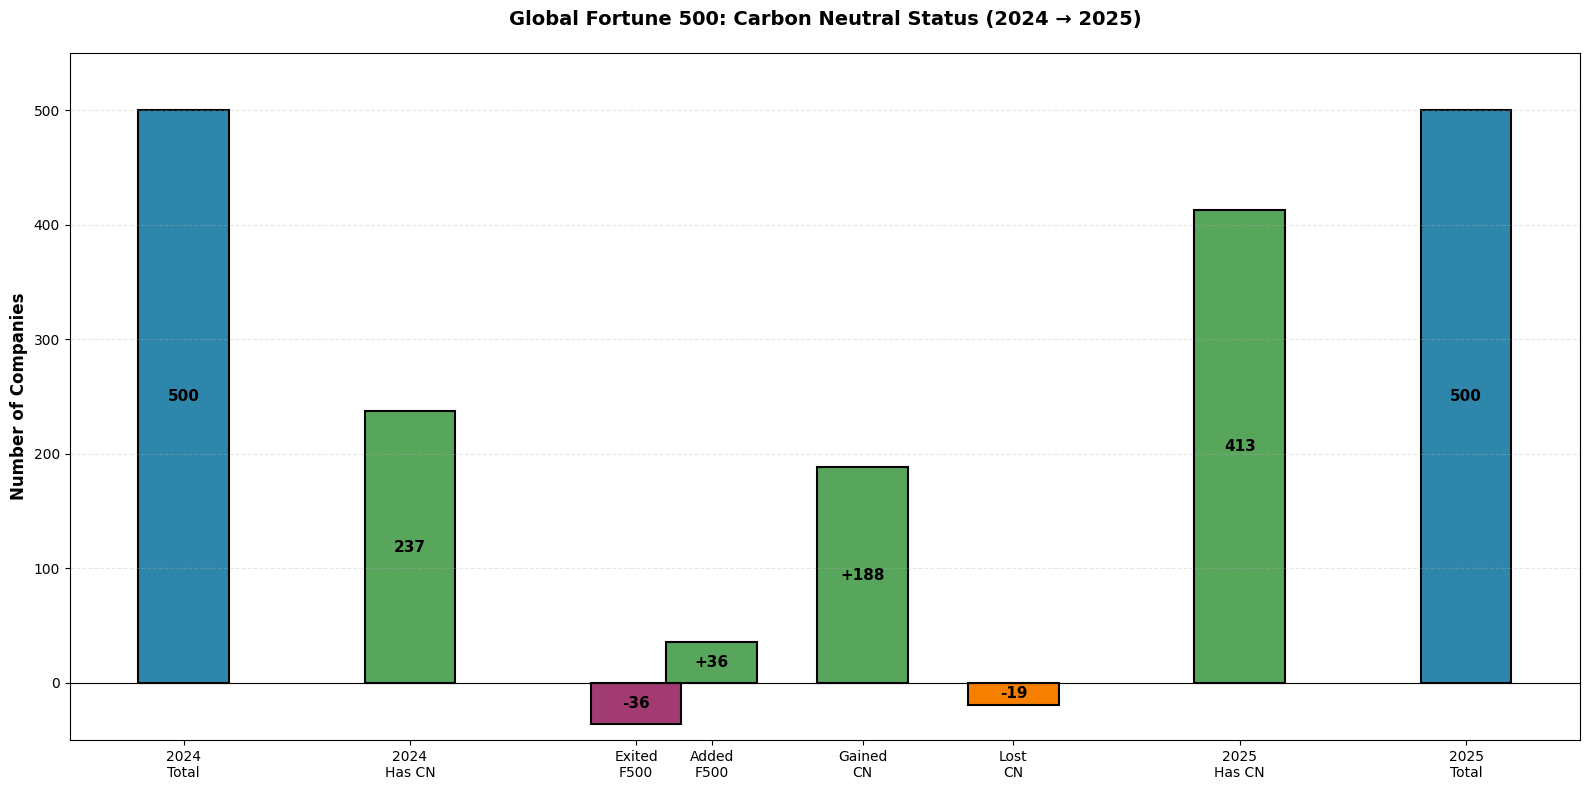

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

def map_cn_2024(row):
    cn = str(row['Carbon neutral commitment (C = company, V = value chain, G= Government, S = subsidiary, U = unspecified, x = less than 50% of rev, N=no)']).strip()
    return 'Has CN' if cn not in ['N', 'nan'] else 'No CN'

def map_cn_2025(row):
    cn = str(row['Carbon neutral commitment (C = company, V = value chain, G= Government, S=Subsidiary,  U = unspecified, N=no)']).strip()
    return 'Has CN' if cn not in ['N', 'nan'] else 'No CN'

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

cn_2024 = sum(1 for c in companies_2024 if map_cn_2024(df_2024_indexed.loc[c]) == 'Has CN')
cn_2025 = sum(1 for c in companies_2025 if map_cn_2025(df_2025_indexed.loc[c]) == 'Has CN')

gained = sum(1 for c in continuing if map_cn_2024(df_2024_indexed.loc[c]) == 'No CN' and map_cn_2025(df_2025_indexed.loc[c]) == 'Has CN')
lost = sum(1 for c in continuing if map_cn_2024(df_2024_indexed.loc[c]) == 'Has CN' and map_cn_2025(df_2025_indexed.loc[c]) == 'No CN')

categories = ['2024\nTotal', '2024\nHas CN', 'Exited\nF500', 'Added\nF500', 'Gained\nCN', 'Lost\nCN', '2025\nHas CN', '2025\nTotal']
base_values = [500, cn_2024, -len(companies_2024 - companies_2025), len(companies_2025 - companies_2024), gained, -lost, cn_2025, 500]

fig, ax = plt.subplots(figsize=(16, 8))
x_positions = [0, 1.5, 3, 3.5, 4.5, 5.5, 7, 8.5]

for i, (x, val) in enumerate(zip(x_positions, base_values)):
    if i == 0 or i == 7:
        ax.bar(x, val, color='#2E86AB', width=0.6, edgecolor='black', linewidth=1.5)
        ax.text(x, val/2, f'{val}', ha='center', va='center', fontsize=11, fontweight='bold')
    elif i == 1 or i == 6:
        ax.bar(x, val, color='#58A55C', width=0.6, edgecolor='black', linewidth=1.5)
        ax.text(x, val/2, f'{val}', ha='center', va='center', fontsize=11, fontweight='bold')
    else:
        col = '#A23B72' if i == 2 else '#58A55C' if val > 0 else '#F77F00'
        ax.bar(x, abs(val), bottom=0 if val > 0 else val, color=col, width=0.6, edgecolor='black', linewidth=1.5)
        ax.text(x, val/2, f'{val:+d}', ha='center', va='center', fontsize=11, fontweight='bold')

ax.set_xticks(x_positions)
ax.set_xticklabels(categories, fontsize=10)
ax.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax.set_title('Global Fortune 500: Carbon Neutral Status (2024 → 2025)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylim(-50, 550)
plt.tight_layout()
plt.savefig('waterfall_carbon_neutral.png', dpi=300, bbox_inches='tight')
plt.show()

changes = []
for company in continuing:
    old = map_cn_2024(df_2024_indexed.loc[company])
    new = map_cn_2025(df_2025_indexed.loc[company])
    if old != new:
        changes.append({'Company': company, '2024': old, '2025': new})

pd.DataFrame(changes).to_excel('carbon_neutral_changes.xlsx', index=False)

In [66]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

def map_cn_2024(row):
    cn = str(row['Carbon neutral commitment (C = company, V = value chain, G= Government, S = subsidiary, U = unspecified, x = less than 50% of rev, N=no)']).strip()
    return 'Has CN' if cn not in ['N', 'nan'] else 'No CN'

def map_cn_2025(row):
    cn = str(row['Carbon neutral commitment (C = company, V = value chain, G= Government, S=Subsidiary,  U = unspecified, N=no)']).strip()
    return 'Has CN' if cn not in ['N', 'nan'] else 'No CN'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

transitions = {}
for company in continuing:
    old = map_cn_2024(df_2024_indexed.loc[company])
    new = map_cn_2025(df_2025_indexed.loc[company])
    transitions[(old, new)] = transitions.get((old, new), 0) + 1

labels = ['2024: Has CN', '2024: No CN', '2025: Has CN', '2025: No CN']
label_map = {'Has CN': 0, 'No CN': 1}

source, target, value, link_colors = [], [], [], []

for (old, new), count in transitions.items():
    src = label_map[old]
    tgt = label_map[new] + 2
    source.append(src)
    target.append(tgt)
    value.append(count)
    
    # Color by source category
    if src == 0:  # Has CN
        link_colors.append('rgba(35, 55, 111, 0.5)')
    else:  # No CN
        link_colors.append('rgba(173, 194, 230, 0.5)')

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels, color=["#23376F", "#ADC2E6", "#532C15", "#D7BC93"]),
    link=dict(source=source, target=target, value=value, color=link_colors)
)])

fig.update_layout(title_text="Carbon Neutral Transitions (2024 → 2025)", font_size=12, height=600)
fig.write_html('sankey_carbon_neutral.html')

## Net Zero

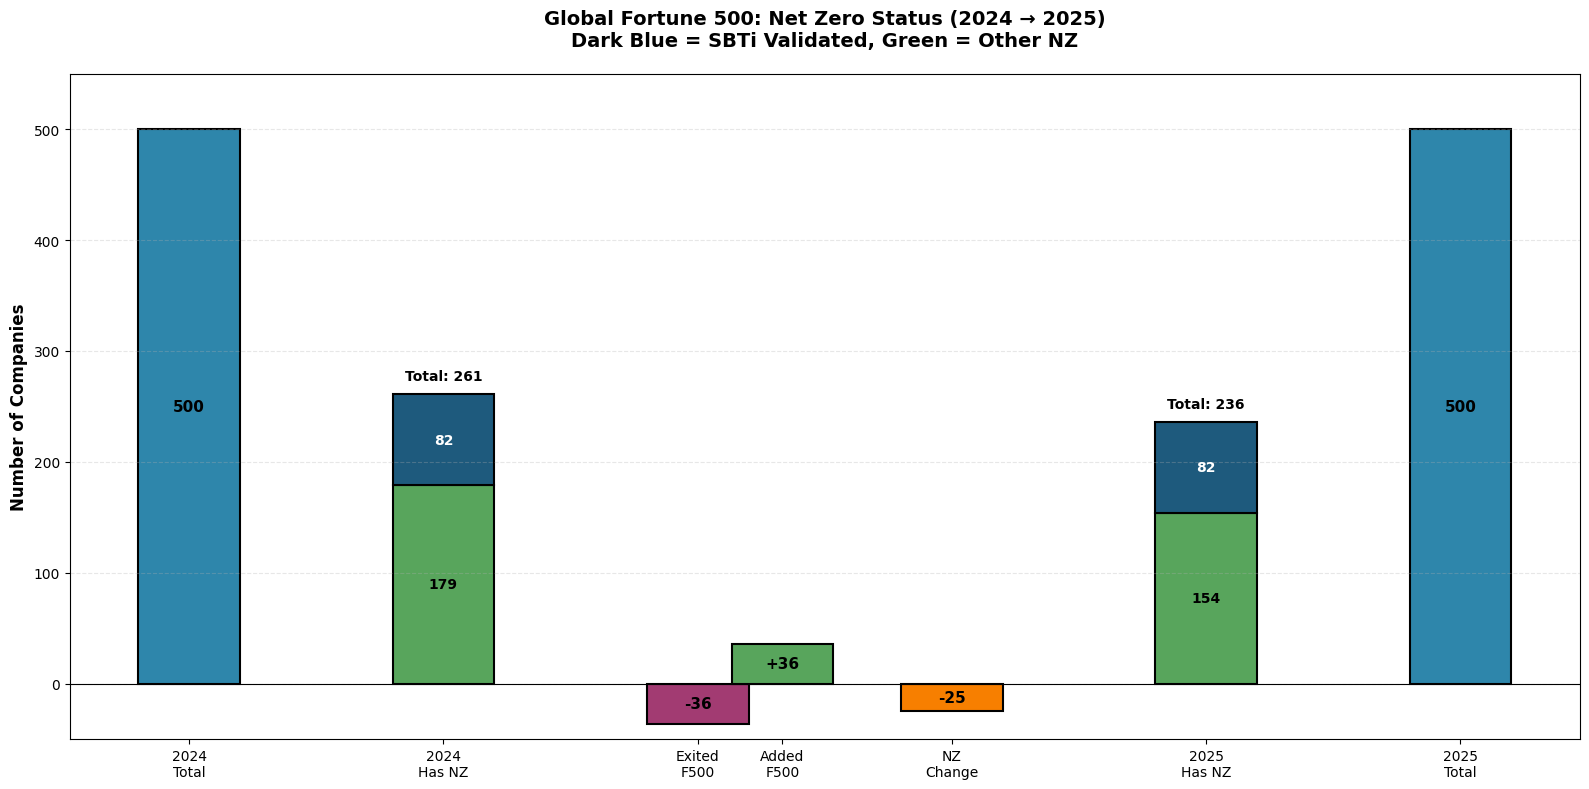

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

def map_nz_2024(row):
    nz = str(row['Net zero commitment (V = value chain, C = company, S = subsidiary, U = unclear, x = less than 50% rev)']).strip()
    sbti = str(row['Net zero committed (SBTi)']).strip()
    if sbti in ['Yes', 'Y']:
        return 'NZ (SBTi)'
    elif nz not in ['N', 'nan', '']:
        return 'NZ (Other)'
    return 'No NZ'

def map_nz_2025(row):
    nz = str(row['Net zero commitment (V = value chain, C = company,  U = unclear, S=Subsidiary)']).strip()
    sbti = str(row['Net zero committed (SBTi) (Y = yes, N = no)']).strip()
    sbti_status = str(row['SBTi NZ Target Status']).strip()
    if sbti in ['Yes', 'Y'] or sbti_status in ['Targets set', 'Targets Set']:
        return 'NZ (SBTi)'
    elif nz not in ['N', 'nan', '']:
        return 'NZ (Other)'
    return 'No NZ'

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

nz_sbti_2024 = sum(1 for c in companies_2024 if map_nz_2024(df_2024_indexed.loc[c]) == 'NZ (SBTi)')
nz_other_2024 = sum(1 for c in companies_2024 if map_nz_2024(df_2024_indexed.loc[c]) == 'NZ (Other)')
nz_sbti_2025 = sum(1 for c in companies_2025 if map_nz_2025(df_2025_indexed.loc[c]) == 'NZ (SBTi)')
nz_other_2025 = sum(1 for c in companies_2025 if map_nz_2025(df_2025_indexed.loc[c]) == 'NZ (Other)')

nz_total_2024 = nz_sbti_2024 + nz_other_2024
nz_total_2025 = nz_sbti_2025 + nz_other_2025

categories = ['2024\nTotal', '2024\nHas NZ', 'Exited\nF500', 'Added\nF500', 'NZ\nChange', '2025\nHas NZ', '2025\nTotal']
base_values = [500, nz_total_2024, -len(companies_2024 - companies_2025), 
               len(companies_2025 - companies_2024), nz_total_2025 - nz_total_2024, 
               nz_total_2025, 500]

fig, ax = plt.subplots(figsize=(16, 8))
x_positions = [0, 1.5, 3, 3.5, 4.5, 6, 7.5]

for i, (x, val) in enumerate(zip(x_positions, base_values)):
    if i == 0 or i == 6:
        ax.bar(x, val, color='#2E86AB', width=0.6, edgecolor='black', linewidth=1.5)
        ax.text(x, val/2, f'{val}', ha='center', va='center', fontsize=11, fontweight='bold')
    elif i == 1:
        ax.bar(x, nz_other_2024, color='#58A55C', width=0.6, edgecolor='black', linewidth=1.5)
        ax.bar(x, nz_sbti_2024, bottom=nz_other_2024, color='#1E5A7D', width=0.6, edgecolor='black', linewidth=1.5)
        ax.text(x, nz_other_2024/2, f'{nz_other_2024}', ha='center', va='center', fontsize=10, fontweight='bold')
        ax.text(x, nz_other_2024 + nz_sbti_2024/2, f'{nz_sbti_2024}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        ax.text(x, val + 10, f'Total: {val}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    elif i == 5:
        ax.bar(x, nz_other_2025, color='#58A55C', width=0.6, edgecolor='black', linewidth=1.5)
        ax.bar(x, nz_sbti_2025, bottom=nz_other_2025, color='#1E5A7D', width=0.6, edgecolor='black', linewidth=1.5)
        ax.text(x, nz_other_2025/2, f'{nz_other_2025}', ha='center', va='center', fontsize=10, fontweight='bold')
        ax.text(x, nz_other_2025 + nz_sbti_2025/2, f'{nz_sbti_2025}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        ax.text(x, val + 10, f'Total: {val}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    else:
        col = '#A23B72' if i == 2 else '#58A55C' if val > 0 else '#F77F00'
        ax.bar(x, abs(val), bottom=0 if val > 0 else val, color=col, width=0.6, edgecolor='black', linewidth=1.5)
        ax.text(x, val/2, f'{val:+d}', ha='center', va='center', fontsize=11, fontweight='bold')

ax.set_xticks(x_positions)
ax.set_xticklabels(categories, fontsize=10)
ax.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax.set_title('Global Fortune 500: Net Zero Status (2024 → 2025)\nDark Blue = SBTi Validated, Green = Other NZ', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylim(-50, 550)
plt.tight_layout()
plt.savefig('waterfall_net_zero.png', dpi=300, bbox_inches='tight')
plt.show()

changes = []
for company in continuing:
    old = map_nz_2024(df_2024_indexed.loc[company])
    new = map_nz_2025(df_2025_indexed.loc[company])
    if old != new:
        changes.append({'Company': company, '2024': old, '2025': new})

pd.DataFrame(changes).to_excel('net_zero_changes.xlsx', index=False)

In [64]:
import pandas as pd
import plotly.graph_objects as go

df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

def map_nz_2024(row):
    sbti = str(row['Net zero committed (SBTi)']).strip()
    nz = str(row['Net zero commitment (V = value chain, C = company, S = subsidiary, U = unclear, x = less than 50% rev)']).strip()
    if sbti in ['Yes', 'Y']:
        return 'NZ (SBTi)'
    elif nz not in ['N', 'nan', '']:
        return 'NZ (Other)'
    return 'No NZ'

def map_nz_2025(row):
    sbti = str(row['Net zero committed (SBTi) (Y = yes, N = no)']).strip()
    sbti_status = str(row['SBTi NZ Target Status']).strip()
    nz = str(row['Net zero commitment (V = value chain, C = company,  U = unclear, S=Subsidiary)']).strip()
    if sbti in ['Yes', 'Y'] or sbti_status in ['Targets set', 'Targets Set']:
        return 'NZ (SBTi)'
    elif nz not in ['N', 'nan', '']:
        return 'NZ (Other)'
    return 'No NZ'

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

transitions = {}
for company in continuing:
    old = map_nz_2024(df_2024_indexed.loc[company])
    new = map_nz_2025(df_2025_indexed.loc[company])
    transitions[(old, new)] = transitions.get((old, new), 0) + 1

labels = ['2024: NZ (SBTi)', '2024: NZ (Other)', '2024: No NZ', 
          '2025: NZ (SBTi)', '2025: NZ (Other)', '2025: No NZ']
label_map = {'NZ (SBTi)': 0, 'NZ (Other)': 1, 'No NZ': 2}

source, target, value, link_colors = [], [], [], []

for (old, new), count in transitions.items():
    src = label_map[old]
    tgt = label_map[new] + 3
    source.append(src)
    target.append(tgt)
    value.append(count)
    
    # Color by source category
    if src == 0:  # NZ (SBTi)
        link_colors.append('rgba(237, 163, 219, 0.5)')
    elif src == 1:  # NZ (Other)
        link_colors.append('rgba(220, 242, 170, 0.5)')
    else:  # No NZ
        link_colors.append('rgba(161, 102, 117, 0.5)')

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels, 
              color=["#EDA3DB", "#DCF2AA", "#A16675", "#9AA7CA", "#5B8449", "#A9DBF6"]),
    link=dict(source=source, target=target, value=value, color=link_colors)
)])

fig.update_layout(title_text="Net Zero Transitions (2024 → 2025)", font_size=12, height=600)
fig.write_html('sankey_net_zero.html')